In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('./dataset/Jakarta-Exchange.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/09/2023,"6,799.79","6,776.37","6,824.66","6,776.37",11.32B,0.35%
1,03/08/2023,"6,776.37","6,766.76","6,776.37","6,728.19",14.41B,0.14%
2,03/07/2023,"6,766.76","6,806.86","6,812.96","6,758.00",14.04B,-0.59%
3,03/06/2023,"6,807.00","6,813.92","6,856.57","6,801.19",13.71B,-0.10%
4,03/03/2023,"6,813.64","6,857.42","6,884.12","6,804.48",11.87B,-0.64%
...,...,...,...,...,...,...,...
1023,01/08/2019,"6,262.85","6,292.26","6,316.24","6,251.38",9.05B,-0.39%
1024,01/07/2019,"6,287.22","6,317.63","6,354.76","6,287.22",9.03B,0.20%
1025,01/04/2019,"6,274.54","6,211.10","6,274.54","6,200.85",8.09B,0.86%
1026,01/03/2019,"6,221.01","6,176.15","6,221.01","6,176.15",7.22B,0.64%


dataset memiliki 1028 baris data dengan 7 kolom, dengan tipe data object
(kategorikal)

In [3]:
df.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,1028,1028,1028,1028,1028,1027,1028
unique,1028,1025,1027,1024,1023,839,356
top,03/09/2023,"6,165.62","6,346.01","6,146.40","4,879.13",11.87B,0.38%
freq,1,2,2,2,2,6,12


Dari statistik data (masih dalam tipe object), terlihat ada kemungkinan missing value
dikolom Vol.

# Preprocessing data

In [4]:
# hapus baris dengan missing value
df = df.dropna()

In [5]:
# Mengubah tipe data kolom Date menjadi datetime
df['Date'] = pd.to_datetime(df['Date'])
# Mengubah tipe data kolom Price,dan lainya menjadi float
columns_harga = ['Price', 'Open', 'High', 'Low']
df[columns_harga] = df[columns_harga].replace(',', '', regex=True).astype(float)
#Ubah tipe data kolom Vol. menjadi tipe data numerik:
df['Vol.'] = df['Vol.'].str.replace(',', '')
df['Vol.'] = df['Vol.'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float)
#Ubah tipe data kolom Change % menjadi tipe data numerik:
df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float)
# urutkan berdasarkan tanggal
df = df.sort_values('Date') 
# set index tanggal
df = df.set_index('Date')
df


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,6181.17,6197.87,6205.90,6164.83,5.28,0.22
2019-01-03,6221.01,6176.15,6221.01,6176.15,7.22,0.64
2019-01-04,6274.54,6211.10,6274.54,6200.85,8.09,0.86
2019-01-07,6287.22,6317.63,6354.76,6287.22,9.03,0.20
2019-01-08,6262.85,6292.26,6316.24,6251.38,9.05,0.39
...,...,...,...,...,...,...
2023-03-03,6813.64,6857.42,6884.12,6804.48,11.87,0.64
2023-03-06,6807.00,6813.92,6856.57,6801.19,13.71,0.10
2023-03-07,6766.76,6806.86,6812.96,6758.00,14.04,0.59


# Normalisasi data
- Normalisasi adalah proses transformasi data agar nilainya berada dalam rentang tertentu
atau memiliki skala yang seragam. Normalisasi ini berguna dalam mempersiapkan data
sebelum dilakukan proses pemodelan atau analisis lebih lanju
- .
Normalisasi hanya dilakukan pada fitur-fitur numerik dalam dataset, sementara fitur-fitur
kategorikal atau teks biasanya tidak diubah menggunakan metode normalisasi ini.ini.

In [6]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [7]:
# Membagi dataset menjadi data latih dan data uji secara acak
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [8]:
# Fungsi untuk membuat dataset dengan time steps
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 1]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
# Membuat dataset dengan time steps
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [9]:
# Membangun model sequential
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [10]:
# Melatih model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
820/820 - 4s - loss: 0.0629 - 4s/epoch - 5ms/step
Epoch 2/100
820/820 - 2s - loss: 0.0441 - 2s/epoch - 2ms/step
Epoch 3/100
820/820 - 2s - loss: 0.0417 - 2s/epoch - 2ms/step
Epoch 4/100
820/820 - 2s - loss: 0.0412 - 2s/epoch - 2ms/step
Epoch 5/100
820/820 - 2s - loss: 0.0408 - 2s/epoch - 2ms/step
Epoch 6/100
820/820 - 2s - loss: 0.0405 - 2s/epoch - 2ms/step
Epoch 7/100
820/820 - 2s - loss: 0.0408 - 2s/epoch - 3ms/step
Epoch 8/100
820/820 - 2s - loss: 0.0406 - 2s/epoch - 3ms/step
Epoch 9/100
820/820 - 2s - loss: 0.0407 - 2s/epoch - 3ms/step
Epoch 10/100
820/820 - 2s - loss: 0.0407 - 2s/epoch - 2ms/step
Epoch 11/100
820/820 - 2s - loss: 0.0408 - 2s/epoch - 2ms/step
Epoch 12/100
820/820 - 2s - loss: 0.0407 - 2s/epoch - 2ms/step
Epoch 13/100
820/820 - 2s - loss: 0.0402 - 2s/epoch - 2ms/step
Epoch 14/100
820/820 - 2s - loss: 0.0404 - 2s/epoch - 2ms/step
Epoch 15/100
820/820 - 2s - loss: 0.0404 - 2s/epoch - 2ms/step
Epoch 16/100
820/820 - 2s - loss: 0.0409 - 2s/epoch - 3ms/step
E

In [11]:
# Melakukan prediksi/ menguji dengan model yang telah dibuat
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

7/7 [==============================] - 0s 5ms/step


In [12]:
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
#menampilkan model yang dibangun
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
# Mengubah dimensi trainPredict, testPredict, trainY, dan testY
trainPredict = trainPredict.reshape(-1,)
testPredict = testPredict.reshape(-1,)
trainY = trainY.reshape(-1,)
testY = testY.reshape(-1,)
# Menampilkan hasil prediksi
print('Hasil Prediksi Data Train:')
print(trainPredict)
print('Hasil Prediksi Data Tes:')
print(testPredict)


Hasil Prediksi Data Train:
[0.6529779  0.653164   0.6538129  0.6573291  0.6536926  0.64340585
 0.64406264 0.6461005  0.6509359  0.64321715 0.64401174 0.67199683
 0.64476615 0.6422897  0.6568837  0.6524036  0.6426132  0.6533345
 0.64735657 0.66500336 0.64497864 0.64443976 0.64387584 0.6652324
 0.6500943  0.6494192  0.6680952  0.65226704 0.65025425 0.6535119
 0.64407617 0.65396214 0.6507951  0.6561928  0.6532664  0.6444874
 0.64900315 0.65101206 0.65438676 0.66776264 0.64081687 0.6654854
 0.6710314  0.6422241  0.64544326 0.65402555 0.6466894  0.65083367
 0.6535842  0.65540624 0.6525583  0.6718924  0.6546414  0.64173424
 0.6517575  0.6534935  0.66569483 0.6494722  0.65532386 0.6487593
 0.6518391  0.6512568  0.66877866 0.65518624 0.6465299  0.65055144
 0.6516118  0.6428914  0.6516818  0.6659883  0.65452874 0.65331215
 0.6507679  0.6516359  0.6681651  0.66426456 0.6511908  0.6652077
 0.6553731  0.65403986 0.6622623  0.66218066 0.64874196 0.6441018
 0.6554141  0.65380156 0.6470275  0.6519517

## Penjelasan Kode

trainPredict = trainPredict.reshape(-1,) digunakan untuk mengubah dimensi dari
trainPredict menjadi satu dimensi. Ini berguna jika sebelumnya trainPredict memiliki
dimensi yang berbeda dan perlu diubah agar sesuai dengan format yang diharapkan.
testPredict = testPredict.reshape(-1,) digunakan untuk mengubah dimensi dari testPredict
menjadi satu dimensi, dengan tujuan yang sama seperti di atas.
trainY = trainY.reshape(-1,) digunakan untuk mengubah dimensi dari trainY menjadi satu
dimensi.
testY = testY.reshape(-1,) digunakan untuk mengubah dimensi dari testY menjadi satu
dimensi.
Setelah mengubah dimensi variabel tersebut, kode berikutnya adalah untuk menampilkan
hasil prediksi. print('Hasil Prediksi Data Train:') digunakan untuk mencetak judul atau label
yang menunjukkan bahwa hasil yang akan ditampilkan adalah hasil prediksi untuk data
latih. Kemudian print(trainPredict) akan mencetak nilai-nilai hasil prediksi untuk data latih.
Proses yang sama dilakukan untuk hasil prediksi data uji dengan menggunakan print('Hasil
Prediksi Data Tes:') dan print(testPredict).
Dengan melakukan langkah-langkah ini, kita dapat melihat nilai-nilai hasil prediksi yang
telah diubah dimensinya dan siap untuk dibandingkan dengan nilai aktual.


In [14]:
print(trainPredict[np.isinf(trainPredict)].sum())
print(testPredict[np.isinf(testPredict)].sum())

0.0
0.0


In [15]:
# menghitung MSE dan RMSE pada data latih
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
# menghitung MSE dan RMSE pada data uji
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


Train Score: 0.04 MSE (0.20 RMSE)
Test Score: 0.05 MSE (0.22 RMSE)


## Penjelasan

hasil diatas menunjukkan akurasi prediksi model pada dataset latihan dan dataset uji.

In [16]:
# Menghitung MAE pada data latih
trainMAE = mean_absolute_error(trainY, trainPredict)
print('Train MAE: %.2f' % trainMAE)
# Menghitung MAE pada data uji
testMAE = mean_absolute_error(testY[:-1], testPredict[:-1])
print('Test MAE: %.2f' % testMAE)


Train MAE: 0.16
Test MAE: 0.17


In [17]:
# Menghitung R-squared pada data latih
trainR2 = r2_score(trainY, trainPredict)
print('Train R-squared: %.4f' % trainR2)
# Menghitung R-squared pada data uji
testR2 = r2_score(testY, testPredict)
print('Test R-squared: %.4f' % testR2)

Train R-squared: -0.0175
Test R-squared: -0.0117


## Cek Hasil Prediksi Vs Target

In [18]:
# Menghitung total hasil prediksi
total_prediksi = len(testPredict)

# Menghitung total hasil prediksi yang sesuai dengan target
prediksi_sesuai = 0
for i in range(total_prediksi):
    if testPredict[i] == testY[i]:
        prediksi_sesuai += 1
        
# Menghitung total hasil prediksi yang tidak sesuai dengan target
prediksi_tidak_sesuai = total_prediksi - prediksi_sesuai

# Menampilkan hasil
print("Total Hasil Prediksi:", total_prediksi)
print("Hasil Prediksi Sesuai dengan Target:", prediksi_sesuai)
print("Hasil Prediksi Tidak Sesuai dengan Target:", prediksi_tidak_sesuai)


Total Hasil Prediksi: 205
Hasil Prediksi Sesuai dengan Target: 0
Hasil Prediksi Tidak Sesuai dengan Target: 205


## Visualisasi Hasil Prediksi


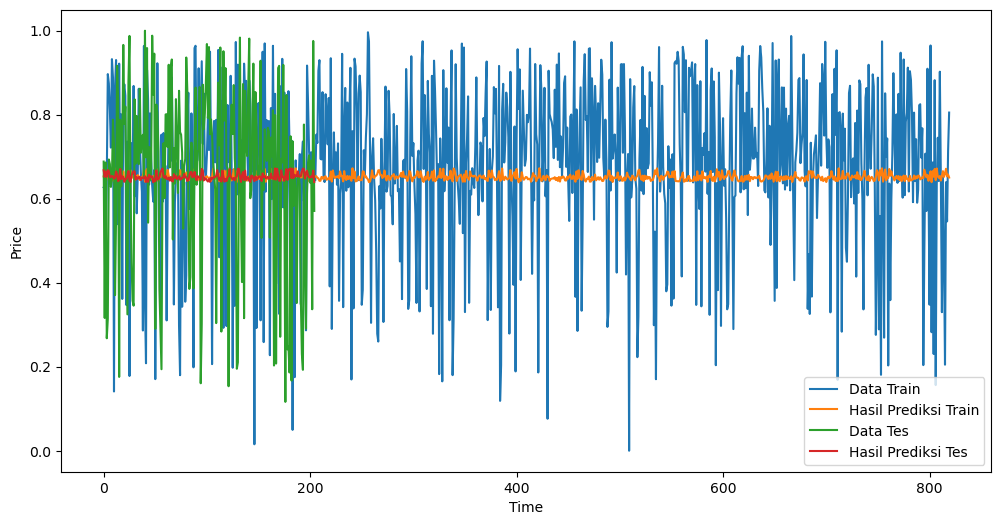

In [19]:
# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(trainY, label='Data Train')
plt.plot(trainPredict, label='Hasil Prediksi Train')
plt.plot(testY, label='Data Tes')
plt.plot(testPredict, label='Hasil Prediksi Tes')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


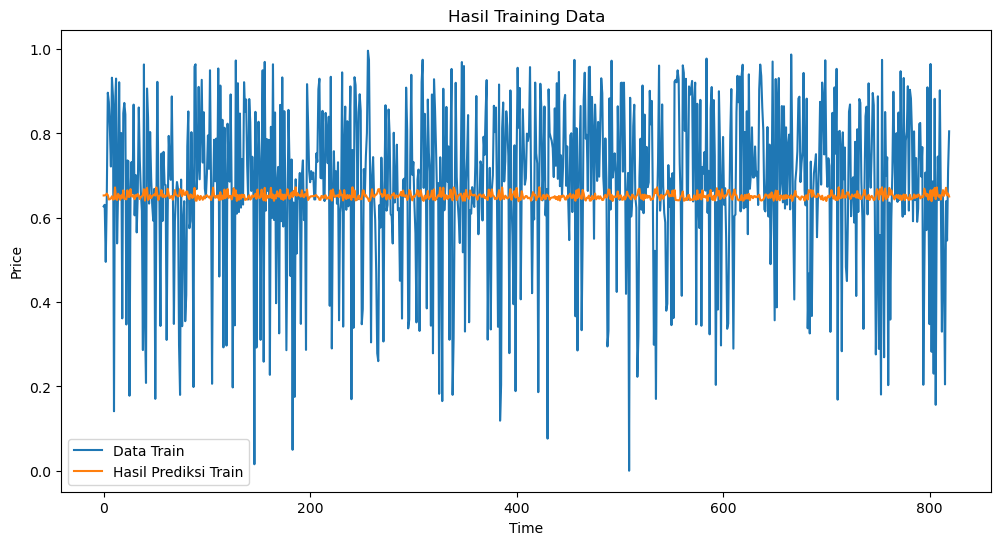

In [20]:
# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(trainY, label='Data Train')
plt.plot(trainPredict, label='Hasil Prediksi Train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Hasil Training Data')
plt.legend()
plt.show()

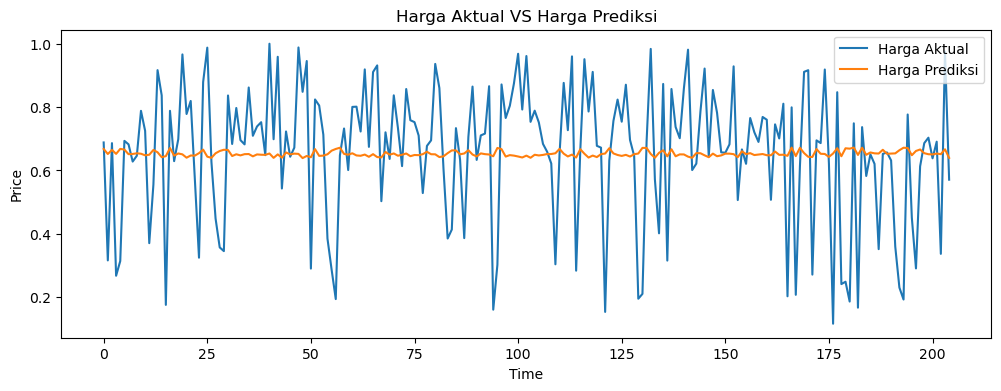

In [21]:
# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 4))
plt.plot(testY, label='Harga Aktual')
plt.plot(testPredict, label='Harga Prediksi')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Harga Aktual VS Harga Prediksi')
plt.legend()
plt.show()


### Dari visualisasi diatas terlihat jelas bahwa harga hasil prediksi tidak sesuai bahkan terlihat jauh selisihnya dengan harga aktual


# HASIL
1. Nilai R-squared untuk data latih dan data uji sangat rendah, berada di sekitar 0. bahkan
minus, Nilai R-squared yang rendah menunjukkan bahwa model yang digunakan tidak
dapat menjelaskan variasi yang diamati dalam data dengan baik.
2. Selain itu, MSE (Mean Squared Error), RMSE (Root Mean Squared Error), dan MAE (Mean
Absolute Error) menunjukkan bahwa model memiliki tingkat kesalahan yang cukup tinggi.
Semakin tinggi nilai MSE, RMSE, dan MAE, semakin besar kesalahan prediksi model
terhadap data aktual.